In [29]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras import backend
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping


# Load dataset

In [30]:
FINAL_DATASET_PATH = os.path.join("final_dataset", "final_dataset.csv")

whole_steam_data = pd.read_csv(FINAL_DATASET_PATH)

In [31]:
whole_steam_data.columns

Index(['Unnamed: 0', 'appid', 'user_reviews', 'desc', 'full_desc', 'popu_tags',
       'name', 'release_date', 'english', 'developer',
       ...
       'Captions available', 'In-App Purchases', 'MMO', 'VR Support',
       'Commentary available', 'Valve Anti-Cheat enabled',
       'Steam Turn Notifications', 'SteamVR Collectibles',
       'Includes Source SDK', 'Mods'],
      dtype='object', length=132)

In [32]:
whole_steam_data.head()

,Unnamed: 0,appid,user_reviews,desc,full_desc,popu_tags,name,release_date,english,developer,...,Captions available,In-App Purchases,MMO,VR Support,Commentary available,Valve Anti-Cheat enabled,Steam Turn Notifications,SteamVR Collectibles,Includes Source SDK,Mods
0,0,10,1,Play the world's number 1 online action game. ...,About This GamePlay the world's number 1 onlin...,ActionFPSMultiplayerShooterClassicTeam-BasedFi...,Counter-Strike,2000-11-01,1,Valve,...,0,0,0,0,0,1,0,0,0,0
1,1,20,1,One of the most popular online action games of...,About This GameOne of the most popular online ...,ActionFPSMultiplayerClassicHero ShooterShooter...,Team Fortress Classic,1999-04-01,1,Valve,...,0,0,0,0,0,1,0,0,0,0
2,2,30,1,Enlist in an intense brand of Axis vs. Allied ...,About This GameEnlist in an intense brand of A...,FPSWorld War IIMultiplayerShooterActionWarTeam...,Day of Defeat,2003-05-01,1,Valve,...,0,0,0,0,0,1,0,0,0,0
3,3,40,0,Enjoy fast-paced multiplayer gaming with Death...,About This GameEnjoy fast-paced multiplayer ga...,ActionFPSClassicMultiplayerShooterFirst-Person...,Deathmatch Classic,2001-06-01,1,Valve,...,0,0,0,0,0,1,0,0,0,0
4,4,50,1,Return to the Black Mesa Research Facility as ...,About This GameReturn to the Black Mesa Resear...,FPSActionClassicSci-fiSingleplayerShooterFirst...,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,...,0,0,0,0,0,1,0,0,0,0


Split dataset into train_data and test_data

In [33]:
from sklearn.model_selection import train_test_split

# 500, 800, 1000, 3600, 5000, 8200, 10_000, 12_000

temp_steam_data = whole_steam_data.head(3000)

X = temp_steam_data.loc[:, temp_steam_data.columns != "user_reviews"]
y = temp_steam_data["user_reviews"]

# X = whole_steam_data.loc[:, whole_steam_data.columns != "user_reviews"]
# y = whole_steam_data["user_reviews"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400, 131) (2400,)
(600, 131) (600,)


In [34]:
print(y_train.value_counts())
print(y_test.value_counts())


1    1331
0    1069
Name: user_reviews, dtype: int64
1    348
0    252
Name: user_reviews, dtype: int64


In [35]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [36]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["english", "windows", "mac", "linux", "achievements", "average_playtime", "median_playtime", "owners", "price", "Indie", "Action", "Adventure", "Casual", "Strategy", "Simulation", "RPG", "Early Access", "Free to Play", "Puzzle", "Racing", "VR", "Sports", "Anime", "Visual Novel", "Platformer", "Point & Click", "Horror", "Nudity", "FPS", "Multiplayer", "Sexual Content", "Violent", "Gore", "Massively Multiplayer", "Hidden Object", "Open World", "Survival", "Pixel Graphics", "Space", "Female Protagonist", "Shoot 'Em Up", "RTS", "Classic", "Turn-Based", "Arcade", "Sci-fi", "Story Rich", "Tower Defense", "Zombies", "Singleplayer", "World War II", "Card Game", "RPGMaker", "Great Soundtrack", "Management", "Co-op", "Fighting", "2D", "Turn-Based Strategy", "Fantasy", "Utilities", "Rogue-like", "Sandbox", "JRPG", "Board Game", "Retro", "Stealth", "Comedy", "Shooter", "Music", "Hack and Slash", "Bullet Hell", "Atmospheric", "First-Person", "City Builder", "Historical", "Psychological Horror", "Family Friendly", "Memes", "Match 3", "Mystery", "Difficult", "Local Multiplayer", "Driving", "Design & Illustration", "Cyberpunk", "Flight", "Building", "Clicker", "Walking Simulator", "Metroidvania", "Education", "Single-player", "Steam Achievements", "Steam Trading Cards", "Steam Cloud", "Full controller support", "Multi-player", "Partial Controller Support", "Steam Leaderboards", "Online Multi-Player", "Shared/Split Screen", "Stats", "Co-op", "Local Multi-Player", "Cross-Platform Multiplayer", "Online Co-op", "Includes level editor", "Steam Workshop", "Local Co-op", "Captions available", "In-App Purchases", "MMO", "VR Support", "Commentary available", "Valve Anti-Cheat enabled", "Steam Turn Notifications", "SteamVR Collectibles", "Includes Source SDK", "Mods"])),
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [37]:
num_pipeline.fit_transform(X_train)

array([[ 0.03537746,  0.        , -0.80942721, ..., -0.02041667,
        -0.067856  , -0.02041667],
       [ 0.03537746,  0.        , -0.80942721, ..., -0.02041667,
        -0.067856  , -0.02041667],
       [ 0.03537746,  0.        , -0.80942721, ..., -0.02041667,
        -0.067856  , -0.02041667],
       ...,
       [ 0.03537746,  0.        , -0.80942721, ..., -0.02041667,
        -0.067856  , -0.02041667],
       [ 0.03537746,  0.        , -0.80942721, ..., -0.02041667,
        -0.067856  , -0.02041667],
       [ 0.03537746,  0.        ,  1.23544154, ..., -0.02041667,
        -0.067856  , -0.02041667]])

In [38]:
# from future_encoders import OneHotEncoder
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["desc", "name", "developer", "release_date"])),
        #("select_cat", DataFrameSelector(["developer"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ])

In [39]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [41]:
seed=25000
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

In [42]:
# for gathering models
models = []


1. Linear SVC

In [43]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LinearSVC(max_iter=50_000))])

param_grid = {
            'classifier__C': [0.25, 0.5, 1, 2, 3, 4]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
models.append(("SVC Linear", grid_1.best_estimator_))
grid_1.best_params_

{'classifier__C': 1}

2. SVC with rbf kernel

In [44]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='rbf'))])

param_grid = {
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}


grid_2 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
models.append(("SVC rbf", grid_2.best_estimator_))
grid_2.best_params_

{'classifier__C': 1, 'classifier__gamma': 0.01}

3. SVC with poly kernel

In [45]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='poly'))])

param_grid = {
            'classifier__degree': [0.1, 1],
            'classifier__coef0': [0, 1],
            'classifier__C': [1, 10]
}

grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
models.append(("SVC poly", grid_3.best_estimator_))
grid_3.best_params_


{'classifier__C': 10, 'classifier__coef0': 0, 'classifier__degree': 1}

4. Logistic Regression

In [46]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression())])

param_grid = {
            'classifier__C': [100, 800, 900, 1000, 1200, 1300, 1500, 1700],
            'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
}


grid_4 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
models.append(("LogisticRegression", grid_4.best_estimator_))
grid_4.best_params_

d:\AppTrue\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\AppTrue\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

{'classifier__C': 100, 'classifier__penalty': 'l2'}

5. DecisionTreeClassifier

In [47]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', DecisionTreeClassifier())])

param_grid = {
            'classifier__max_depth': [1, 5, 10, 15, 20],
            'classifier__max_leaf_nodes': [None, 5, 10, 20, 45, 90],
}


grid_5 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
models.append(("DecisionTreeClassifier", grid_5.best_estimator_))
grid_5.best_params_

{'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 10}

6. RandomForestClassifier

In [48]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', RandomForestClassifier(n_jobs=-1))])

param_grid = {
            'classifier__n_estimators' : [1, 3, 5, 8, 40, 50],
            'classifier__max_leaf_nodes' : [2, 4, 8, 16, 32, 64]
}

grid_6 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
models.append(("RandomForestClassifier", grid_6.best_estimator_))
grid_6.best_params_

{'classifier__max_leaf_nodes': 64, 'classifier__n_estimators': 40}

7. ExtraTreesClassifier

In [49]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', ExtraTreesClassifier(n_jobs=-1))])

param_grid = {
            'classifier__n_estimators' : [1, 3, 5, 8, 40, 50],
            'classifier__max_leaf_nodes' : [2, 4, 8, 16, 32, 64, 128],
}

grid_7 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
models.append(("ExtraTreesClassifier", grid_7.best_estimator_))
grid_7.best_params_

{'classifier__max_leaf_nodes': 128, 'classifier__n_estimators': 50}

8. BaggingClassifier

In [50]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', BaggingClassifier())])

param_grid = {
            'classifier__max_samples' : [0.05, 0.1, 0.2, 0.5, 0.7, 1]
}

grid_8 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
models.append(("BaggingClassifier", grid_8.best_estimator_))
grid_8.best_params_

{'classifier__max_samples': 0.7}

9. KNeighborsClassifier

In [51]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', KNeighborsClassifier(n_jobs=-1))])

param_grid = {
            'classifier__p': [1, 2, 3, 10, 100, 1000, 10000],
}

grid_9 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
models.append(("KNeighborsClassifier", grid_9.best_estimator_))
grid_9.best_params_

d:\AppTrue\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\AppTrue\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\AppTrue\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "d:\AppTrue\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, 

{'classifier__p': 2}

10. AdaBoostClassifier

In [52]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', AdaBoostClassifier())])


param_grid = {
            'classifier__n_estimators' : [100, 500, 600, 700],
            'classifier__learning_rate' : [0.5, 0.6, 0.7, 1],
}

grid_10 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_10.fit(X_train, y_train)
models.append(("AdaBoostClassifier", grid_10.best_estimator_))
grid_10.best_params_

{'classifier__learning_rate': 0.6, 'classifier__n_estimators': 500}

11. Neural Networks

In [79]:
# for gathering deep models
deep_models = []

In [54]:
X_train_scaled = preprocess_pipeline.transform(X_train)
X_test_scaled = preprocess_pipeline.transform(X_test)

In [80]:
backend.clear_session()

history = History()
model_1 = Sequential()

model_1.add(Dense(1000,activation="elu",input_shape=(X_train_scaled.shape[1],)))
model_1.add(Dropout(0.2))
model_1.add(Dense(250, activation="sigmoid"))
model_1.add(Dropout(0.2))
model_1.add(Dense(50, activation="elu"))
model_1.add(Dense(1, activation="relu"))

model_1.summary()

# model_1.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model_1.compile(loss="poisson", optimizer="Adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=1)
history = model_1.fit(X_train_scaled, y_train, validation_data= (X_test_scaled, y_test), batch_size=32, epochs=200, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              7743000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               250250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 8,005,851
Trainable params: 8,005,851
Non-trainable params: 0
______________________________________________

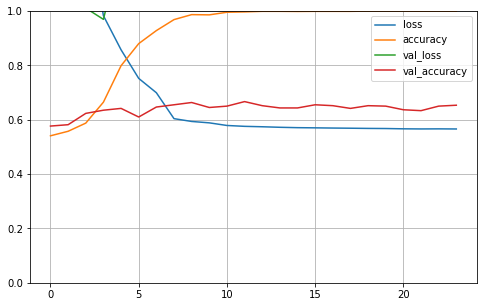

19/19 [==============================] - 0s 3ms/step - loss: 1.1615 - accuracy: 0.6533


In [81]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

test_eval = model_1.evaluate(X_test_scaled,y_test)
test_eval

deep_models.append(("Neural Network 1", model_1))

In [84]:
backend.clear_session()

history = History()
model_2 = Sequential()

model_2.add(Dense(500,activation="elu",input_shape=(X_train_scaled.shape[1],)))
model_2.add(Dropout(0.3))
model_2.add(Dense(200, activation="sigmoid"))
model_2.add(Dropout(0.2))
model_2.add(Dense(50, activation="sigmoid"))
model_2.add(Dense(1, activation="relu"))

model_2.summary()

# model_2.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model_2.compile(loss="poisson", optimizer="Adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=1)
history = model_2.fit(X_train_scaled, y_train, validation_data= (X_test_scaled, y_test), batch_size=32, epochs=200, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               3871500   
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 3,981,801
Trainable params: 3,981,801
Non-trainable params: 0
______________________________________________

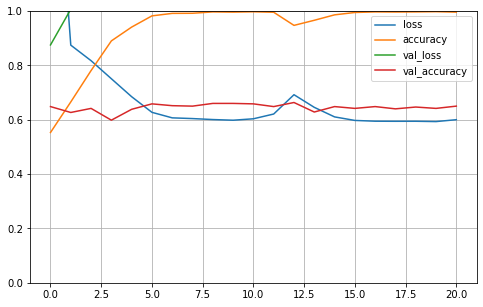

19/19 [==============================] - 0s 5ms/step - loss: 2.1395 - accuracy: 0.6500


In [86]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

test_eval = model_2.evaluate(X_test_scaled,y_test)
test_eval

deep_models.append(("Neural Network 2", model_2))

In [87]:
backend.clear_session()

history = History()
model_3 = Sequential()

model_3.add(Dense(420,activation="sigmoid",input_shape=(X_train_scaled.shape[1],)))
model_3.add(Dense(100, activation="sigmoid"))
model_3.add(Dense(50, activation="sigmoid"))
model_3.add(Dense(1, activation="relu"))

model_3.summary()

# model_3.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model_3.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=1)
history = model_3.fit(X_train_scaled, y_train, validation_data= (X_test_scaled, y_test), batch_size=32, epochs=200, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 420)               3252060   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               42100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 3,299,261
Trainable params: 3,299,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
75/75 [==============================] - 1s 8ms/step - loss: 0.6722 - accuracy: 0.5875 - val_loss: 0.6474 - val_accuracy: 0.6283
Epoch 2/200
75/75 [==============================] - 0s 6ms/step - loss: 0.6224 - accuracy: 0.6754 - va

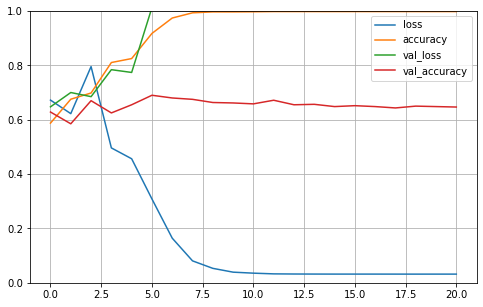

19/19 [==============================] - 0s 3ms/step - loss: 1.2533 - accuracy: 0.6467


In [89]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

test_eval = model_3.evaluate(X_test_scaled,y_test)
test_eval

deep_models.append(("Neural Network 3", model_3))

In [61]:
backend.clear_session()

history = History()
model_4 = Sequential()

model_4.add(Dense(50,activation="elu",input_shape=(X_train_scaled.shape[1],)))
model_4.add(Dense(10, activation="elu"))
model_4.add(Dense(1, activation="relu"))

model_4.summary()

# model_4.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model_4.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=1)
history = model_4.fit(X_train_scaled, y_train, validation_data= (X_test_scaled, y_test), batch_size=32, epochs=200, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                387150    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 387,671
Trainable params: 387,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
75/75 [==============================] - 1s 6ms/step - loss: 4.1723 - accuracy: 0.4767 - val_loss: 3.3267 - val_accuracy: 0.5183
Epoch 2/200
75/75 [==============================] - 0s 4ms/step - loss: 2.8164 - accuracy: 0.6321 - val_loss: 2.8214 - val_accuracy: 0.5683
Epoch 3/200
75/75 [==============================] - 0s 4ms/step - loss: 2.0400 - accuracy: 0.7675

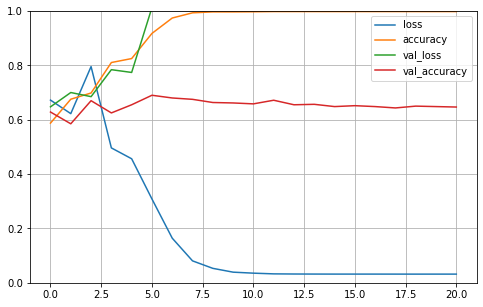

19/19 [==============================] - 0s 3ms/step - loss: 3.1153 - accuracy: 0.5967


In [90]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

test_eval = model_4.evaluate(X_test_scaled,y_test)
test_eval

deep_models.append(("Neural Network 4", model_4))

In [63]:
keras.backend.clear_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-2, input_shape=(X_train_scaled.shape[1],)):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="elu"))
    model.add(keras.layers.Dense(1, activation="relu"))
    # optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="poisson", optimizer="Adam", metrics=["accuracy"])
    return model

In [64]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

In [65]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_accuracy", patience=15, mode="min", verbose=1)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
40/40 [==============================] - 0s 6ms/step - loss: 4.4316 - accuracy: 0.4531 - val_loss: 5.0327 - val_accuracy: 0.4406
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 3.7783 - accuracy: 0.4547 - val_loss: 4.7366 - val_accuracy: 0.4406
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 3.5080 - accuracy: 0.4570 - val_loss: 4.6717 - val_accuracy: 0.4437
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 3.3671 - accuracy: 0.4570 - val_loss: 4.5746 - val_accuracy: 0.4469
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 3.1832 - accuracy: 0.4656 - val_loss: 4.3316 - val_accuracy: 0.4500
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 2.9525 - accuracy: 0.4727 - val_loss: 4.1888 - val_accuracy: 0.4500
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 2.8588 - accuracy: 0

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024730B4AFA0>,
                   param_distributions={'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   verbose=2)

In [91]:
print(rnd_search_cv.best_params_)
deep_models.append(("RandomSearch NN 1", rnd_search_cv.best_estimator_))

{'n_neurons': 60, 'n_hidden': 3}


In [67]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3, 4],
    "n_neurons": np.arange(1, 300)
}

rnd_search_cv_2 = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv_2.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_accuracy", patience=15, mode="min", verbose=1)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
40/40 [==============================] - 1s 10ms/step - loss: 3.9600 - accuracy: 0.4664 - val_loss: 3.9786 - val_accuracy: 0.4625
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 2.8575 - accuracy: 0.5703 - val_loss: 3.1064 - val_accuracy: 0.5500
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 2.2207 - accuracy: 0.6844 - val_loss: 2.9115 - val_accuracy: 0.5406
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 1.9325 - accuracy: 0.8648 - val_loss: 2.8256 - val_accuracy: 0.5219
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 1.7426 - accuracy: 0.8156 - val_loss: 2.6184 - val_accuracy: 0.5719
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 1.6267 - accuracy: 0.9078 - val_loss: 2.5699 - val_accuracy: 0.5719
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 1.5220 - accuracy: 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024730B4AFA0>,
                   param_distributions={'n_hidden': [0, 1, 2, 3, 4],
                                        'n_neurons': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  6...
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 

In [92]:
print(rnd_search_cv_2.best_params_)
deep_models.append(("RandomSearch NN 2", rnd_search_cv_2.best_estimator_))

{'n_neurons': 173, 'n_hidden': 3}


# Summary

In [69]:
def get_recall_score(deep_model, X_test_scaled, y_test):
    recall_keras = keras.metrics.Recall()
    recall_keras.update_state(y_true=y_test, y_pred=(deep_model.predict(X_test_scaled) > 0.5).astype("int32"))
    return recall_keras.result().numpy()

In [70]:
def get_precision_score(deep_model, X_test_scaled, y_test):
    precision_keras = keras.metrics.Precision()
    precision_keras.update_state(y_true=y_test, y_pred=(deep_model.predict(X_test_scaled) > 0.5).astype("int32"))
    return precision_keras.result().numpy()

In [71]:
def get_accuracy_score(deep_model, X_test_scaled, y_test):
    accuracy_keras = keras.metrics.Accuracy()
    accuracy_keras.update_state(y_true=y_test, y_pred=(deep_model.predict(X_test_scaled) > 0.5).astype("int32"))
    return accuracy_keras.result().numpy()

In [72]:
def get_f1_score(deep_model, X_test_scaled, y_test):
    pres = get_precision_score(deep_model, X_test_scaled, y_test)
    rec = get_recall_score(deep_model, X_test_scaled, y_test)

    return (2 * pres * rec) / (pres + rec)

In [73]:
def get_roc_auc_score(deep_model, X_test_scaled, y_test):
    accuracy_keras = keras.metrics.AUC()
    accuracy_keras.update_state(y_true=y_test, y_pred=(deep_model.predict(X_test_scaled) > 0.5).astype("int32"))
    return accuracy_keras.result().numpy()

In [93]:
precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []

for name, model in models:
    print(name)
    print("precision_score: {}".format( metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test, model.predict(X_test)) ))
    print(model.predict(X_test))

    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
    

for name, model in deep_models:
    print(name)
    print("precision_score: {}".format( get_precision_score(model, X_test_scaled, y_test) ))
    print("recall_score: {}".format( get_recall_score(model, X_test_scaled, y_test) ))
    print("f1_score: {}".format( get_f1_score(model, X_test_scaled, y_test) ))
    print("accuracy_score: {}".format( get_accuracy_score(model, X_test_scaled, y_test) ))
    print("roc_auc_score: {}".format( get_roc_auc_score(model, X_test_scaled, y_test) ))

    precision_score.append(get_precision_score(model, X_test_scaled, y_test))
    recall_score.append(get_recall_score(model, X_test_scaled, y_test))
    f1_score.append(get_f1_score(model, X_test_scaled, y_test))
    accuracy_score.append(get_accuracy_score(model, X_test_scaled, y_test))
    roc_auc_score.append(get_roc_auc_score(model, X_test_scaled, y_test))


SVC Linear
precision_score: 0.7236467236467237
recall_score: 0.7298850574712644
f1_score: 0.726752503576538
accuracy_score: 0.6816666666666666
roc_auc_score: 0.6724822112753148
[1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1
 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1
 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0
 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0
 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1
 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1
 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 

Comparison of all statistics:

In [94]:
d = {"precision_score": precision_score, 
     "recall_score": recall_score, 
     "f1_score": f1_score,
     "accuracy_score" : accuracy_score,
     "roc_auc_score" : roc_auc_score
    }

df = pd.DataFrame(data=d)
df.insert(loc=0, column="Model", value=["LinearSVC", "SVC rbf", "SVC poly", "Logistic Regression", "DecisionTreeClassifier", "RandomForestClassifier", "ExtraTreesClassifier", 
                                         "BaggingClassifier", "KNeighborsClassifier", "AdaBoostClassifier", "Neural Network 1", "Neural Network 2", "Neural Network 3", "Neural Network 4", "RandomSearch NN 1", "RandomSearch NN 2"])
df

,Model,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,LinearSVC,0.723647,0.729885,0.726753,0.681667,0.672482
1,SVC rbf,0.707386,0.715517,0.711429,0.663333,0.653394
2,SVC poly,0.734568,0.683908,0.708333,0.673333,0.671319
3,Logistic Regression,0.731429,0.735632,0.733524,0.690000,0.681308
4,DecisionTreeClassifier,0.685139,0.781609,0.730201,0.665000,0.642789
5,RandomForestClassifier,0.676399,0.798851,0.732543,0.661667,0.635536
6,ExtraTreesClassifier,0.676123,0.821839,0.741894,0.668333,0.639094
7,BaggingClassifier,0.698795,0.666667,0.682353,0.640000,0.634921
8,KNeighborsClassifier,0.682635,0.655172,0.668622,0.623333,0.617269
9,AdaBoostClassifier,0.750760,0.709770,0.729690,0.695000,0.692187


Scores:

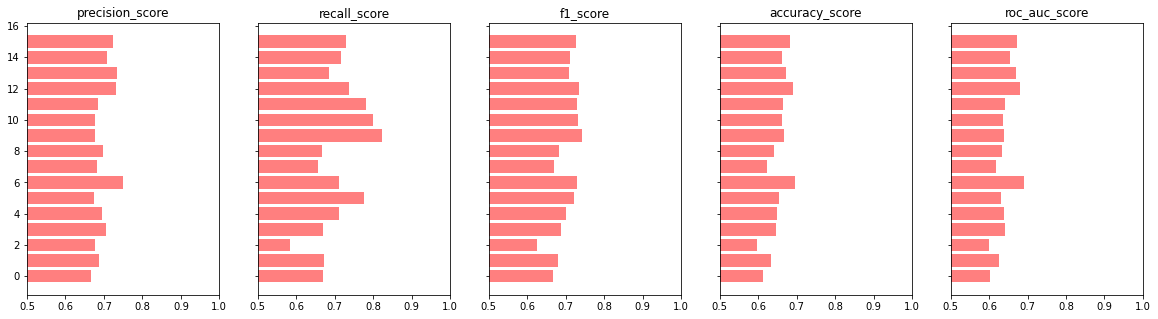

In [95]:
fig, axs = plt.subplots(1, 5, figsize=(20,5), sharey=True)

objects_1 = [name for (name, model) in models]
objects_2 = [name for (name, model) in deep_models]
objects = objects_1 + objects_2
objects.reverse()

y_pos = np.arange(len(objects))

for count, name in enumerate(d):
    performance = d[name]
    performance.reverse()
    colors = ["r" if p < 1 else "b" for p in performance]
    axs[count].barh(y_pos, performance, align="center", alpha=0.5, color=colors)
    axs[count].set_title(name)

for ax in axs:
    ax.set_xlim([0.5,1])

Confusion matrices:

C:\Users\Admin\AppData\Local\Temp\ipykernel_472\1868115283.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


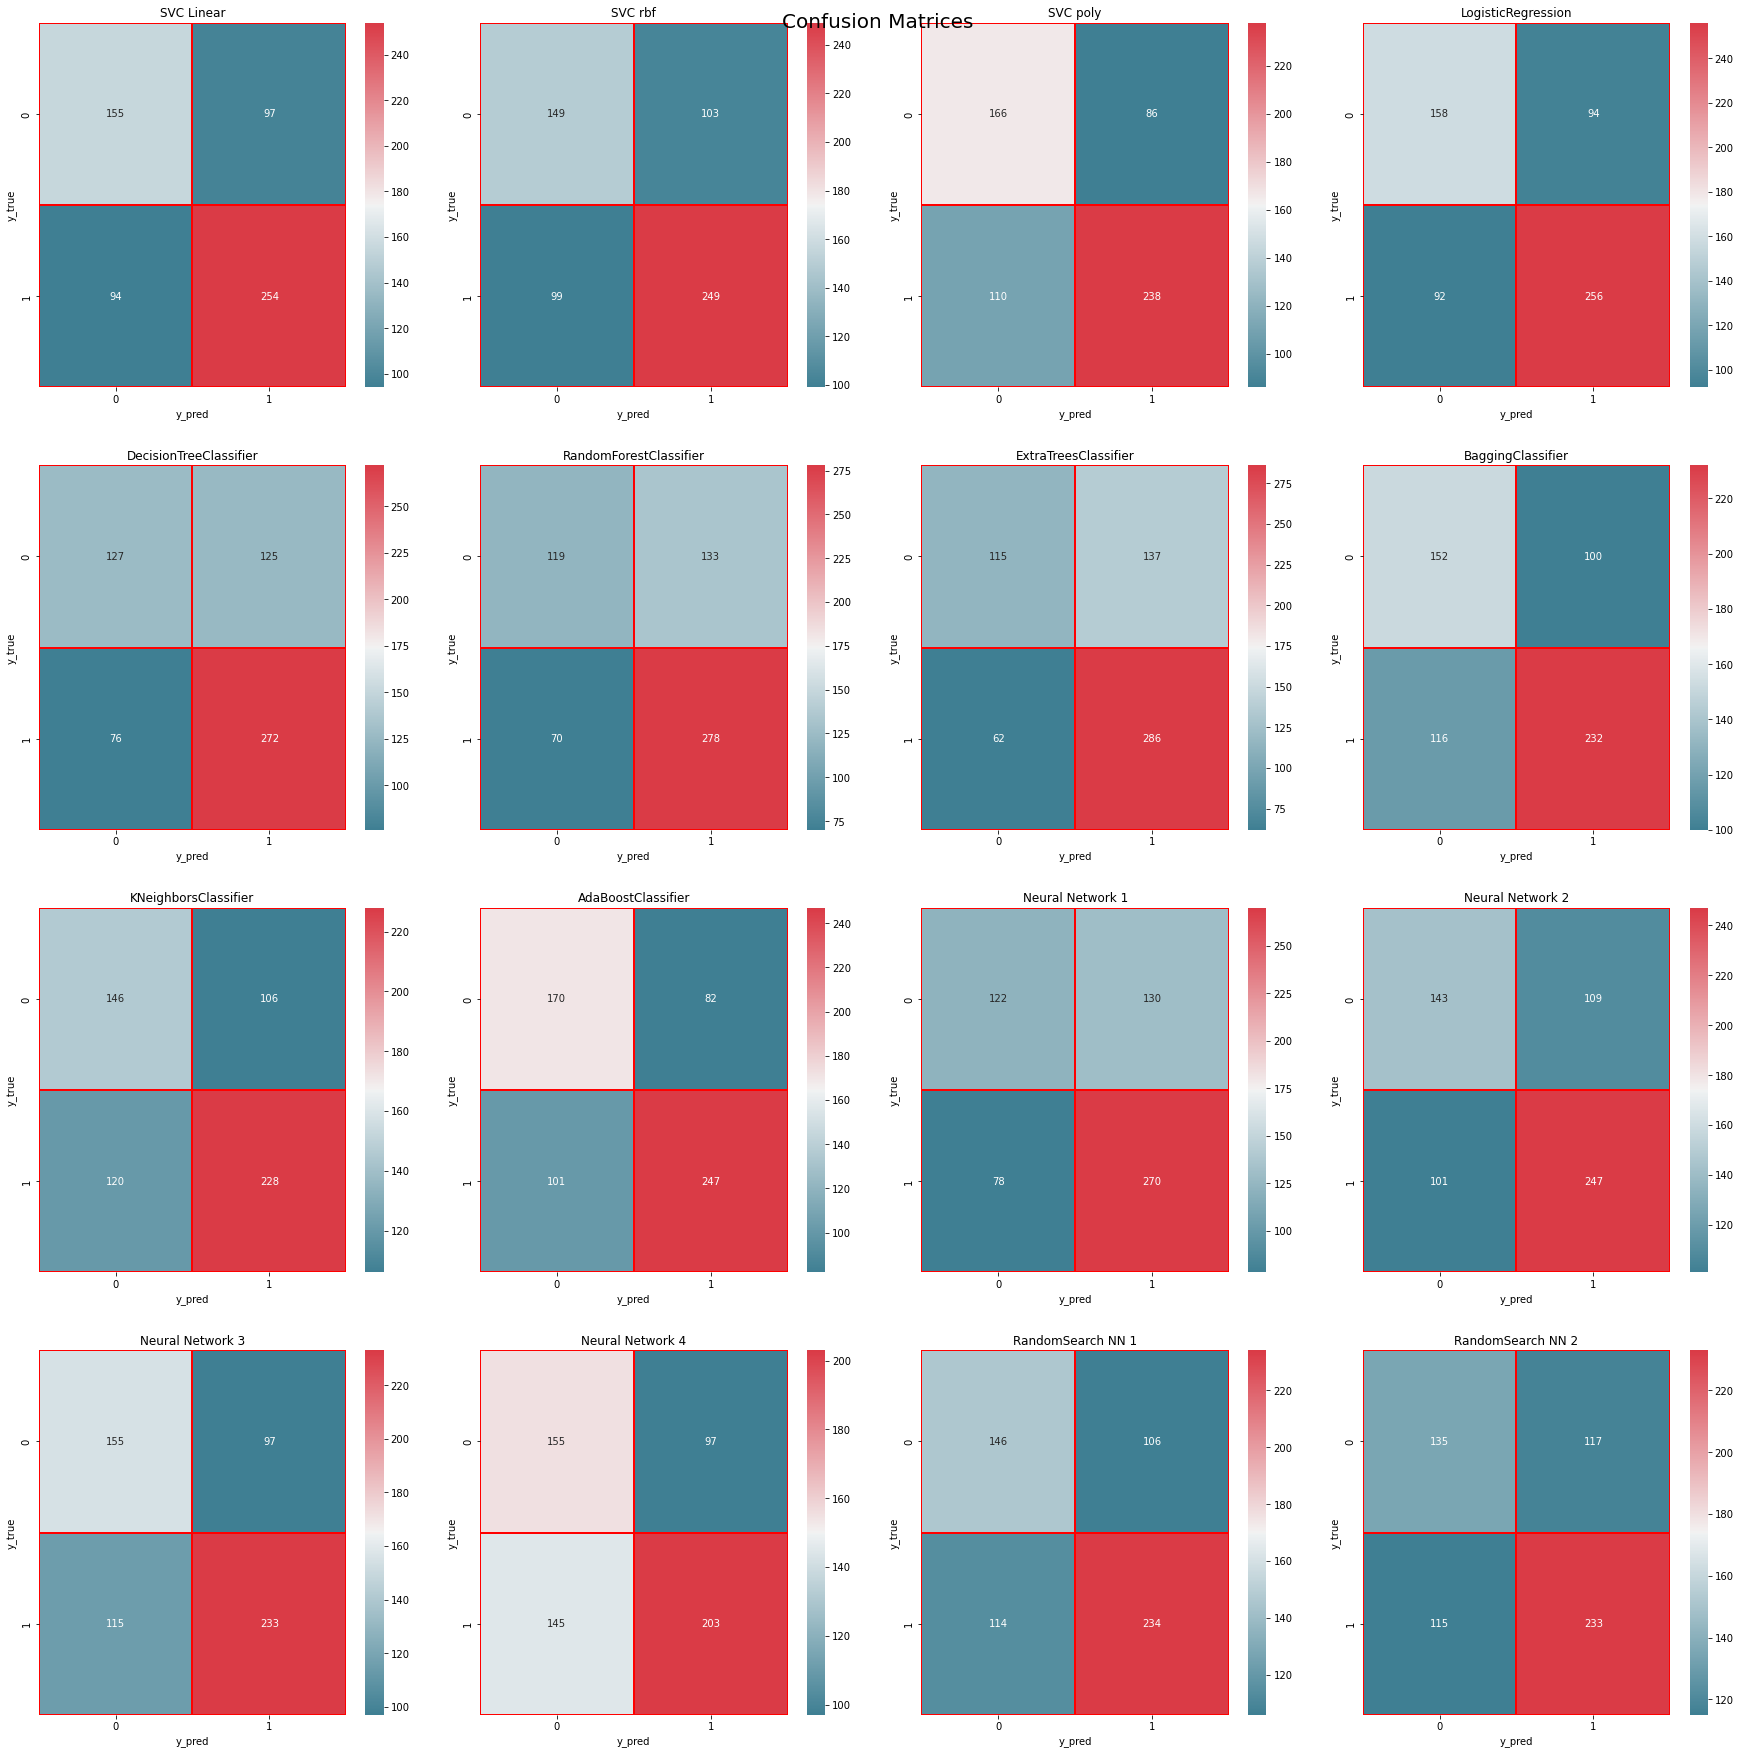

In [96]:
def iterate_count(inner_count, outer_count):
    inner_count += 1
    if inner_count == 4:
        outer_count += 1
        inner_count = 0
    return (inner_count, outer_count)
    

plots_x = 4
plots_y = 4

fig, axs = plt.subplots(plots_x, plots_y, figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


inner_count = 0
outer_count = 0

for name, model in models:
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, linewidths=0.05, linecolor="red", cmap=cmap, fmt=".0f", ax=axs[outer_count, inner_count])
    axs[outer_count, inner_count].set_title(name)

    inner_count, outer_count = iterate_count(inner_count, outer_count)


for name, model in deep_models:
    cm = confusion_matrix(y_test, (model.predict(X_test_scaled) > 0.5).astype("int32"))
    sns.heatmap(cm, annot=True, linewidths=0.05, linecolor="red", cmap=cmap, fmt=".0f", ax=axs[outer_count, inner_count])
    axs[outer_count,inner_count].set_title(name)

    inner_count, outer_count = iterate_count(inner_count, outer_count)


for ax in axs.flat:
    ax.set(xlabel="y_pred", ylabel="y_true")
    ax.label_outer()

fig.tight_layout(pad=3.0)
fig.suptitle("Confusion Matrices", fontsize=20)
fig.show()


# Save the best model

In [97]:
# in that case it was

# model_3.save(r"model/")